In [60]:
from commonfunctions import *
import numpy as np
from skimage.morphology import binary_opening, binary_dilation, binary_erosion, skeletonize
import cv2 as cv
import os
import random
import mediapipe as mp


In [61]:
# get threshold value
def calcThreshold(hist, accHist, iFrom, iTo):
    iFrom, iTo = int(iFrom), int(iTo)
    numOfPixels = accHist[iTo] - (accHist[iFrom - 1] if iFrom > 0 else 0)
    mean = np.sum(
        hist[iFrom:iTo+1] * np.arange(iFrom, iTo+1)
    ) / numOfPixels
    return round(mean)

# np.arange([1 , 2] < 3)


def avgThreshold(hist, accHist, Tinit):
    mean1 = calcThreshold(hist, accHist, 0, Tinit - 1)
    mean2 = calcThreshold(hist, accHist, Tinit, hist.shape[0] - 1)
    newThreshold = round((mean1 + mean2) / 2)
    return newThreshold if Tinit == newThreshold else avgThreshold(hist, accHist, newThreshold)


def getGlobalThreshold(img):
    img2 = np.copy(img)
    hist = np.histogram(img2, bins=np.arange(256))[0]
    accHist = np.cumsum(hist)
    Tinit = calcThreshold(hist, accHist, 0, hist.shape[0] - 1)
    return avgThreshold(hist, accHist, Tinit)# get threshold


In [62]:
# # training functions
# def binary_image(file_name):
#     img = cv.imread(file_name)
#     threshold_val = getGlobalThreshold(img)
#     img = cv.cvtColor(img,  cv.COLOR_BGR2GRAY)
#     _, threshold = cv.threshold(img, threshold_val, 255, 0)
#     return np.array(threshold, dtype=np.float32)


# def edge_image(file_name):
#     img = cv.imread(file_name)
#     img = 255 * rgb2gray(img)
#     threshold = getGlobalThreshold(img)
#     img = canny(img, 0.5, max(threshold - 100, 0), threshold)
#     return np.array(img, dtype=np.float32)


# def read_data_without_processing(base_directory, is_truthy, images):
#     # isRead = False
#     max_num = 100
#     for file_name in os.listdir(base_directory):
#         if max_num <= 0:
#             break
#         img = cv.imread(f"{base_directory}/{file_name}", cv.IMREAD_GRAYSCALE)
#         th = getGlobalThreshold(img)
#         img = img > th
#         img = np.array(img, dtype=np.float32)
#         images.append([img, is_truthy])
#         max_num -= 1


# def read_data_after_detecting_edge(base_directory, new_directory, is_truthy, images):
#     max_num = 1000
#     for file_name in os.listdir(base_directory):
#         if max_num <= 0:
#             break
#         img = edge_image(f"{base_directory}/{file_name}")
#         img = np.array(img, dtype=np.float32)
#         # if max_num % 100 == 0:
#         #     print(img)
#         images.append([img, is_truthy])
#         max_num -= 1


# def resize_data_set(data_set):
#     new_data_set = [None] * len(data_set)
#     for i in range(len(data_set)):
#         new_data_set[i] = cv.resize(data_set[i], (300, 300))
#     return np.array(new_data_set)


# def get_data_set_and_result(images):
#     result = []
#     data_set = []
#     for image in images:
#         print(image[0].shape)
#         data_set.append(image[0])
#         result.append(image[1])
#     return data_set, result


# def reshape_data_set(data_set):
#     print(data_set.shape)
#     a, b, c = data_set.shape
#     print(a, b, c)
#     return data_set.reshape((a, b * c))


In [63]:
# testing

# image_testing = cv.imread(
#     './images/hands/images/dataCE/A/250.jpg', cv.IMREAD_GRAYSCALE
# )
# # show_images([image_testing])
# th = getGlobalThreshold(image_testing)
# image_testing = image_testing > th
# image_testing = np.array(image_testing, dtype=np.float32)
# # show_images([image_testing])


In [64]:
# read  training data (hands)

# images = []
# for i in range(26):
#     char = chr(ord('A') + i)
#     read_data_without_processing(
#         f'./images/hands/images/dataCE/{char}', 1, images
#     )


In [65]:
# read_data_after_detecting_edge(
#     f"./images/clothes/train/train", "./images/clothes/train/edged", 0, images
# )


In [66]:
# read_data_after_detecting_edge(
#     f"./images/faces/105_classes_pins_dataset", "./images/clothes/train/edged", 0, images
# )

In [67]:
# read training data (clothes)


In [68]:
# get data set and result
# print(len(images))
# random.shuffle(images)
# # print(images)
# data_set, result = get_data_set_and_result(images)
# data_set = resize_data_set(data_set)
# print(data_set.shape)
# data_set = reshape_data_set(data_set)

# apply thresholding to convert grayscale to binary image


In [69]:
# data_set = np.matrix(data_set)
# result = np.matrix(result)
# result = np.array(result)
# print(data_set.shape)
# print(result.shape)


In [70]:
# training
# svm = cv.ml.SVM_create()
# svm.setType(cv.ml.SVM_C_SVC)
# svm.setKernel(cv.ml.SVM_SIGMOID)
# svm.setTermCriteria((cv.TERM_CRITERIA_MAX_ITER, 1000, 1e-6))



In [71]:

# # print(data_set[:1000])
# svm.train(data_set,
#           cv.ml.ROW_SAMPLE, result)


In [72]:
# svm.train(data_set[:1000] , cv.ml.ROW_SA)

In [73]:
# def predict(img) -> bool:
#     res = svm.predict(np.matrix(img))
#     print(res)
#     return res[1][0][0]

In [81]:
img = io.imread('./images/image9.jpeg')

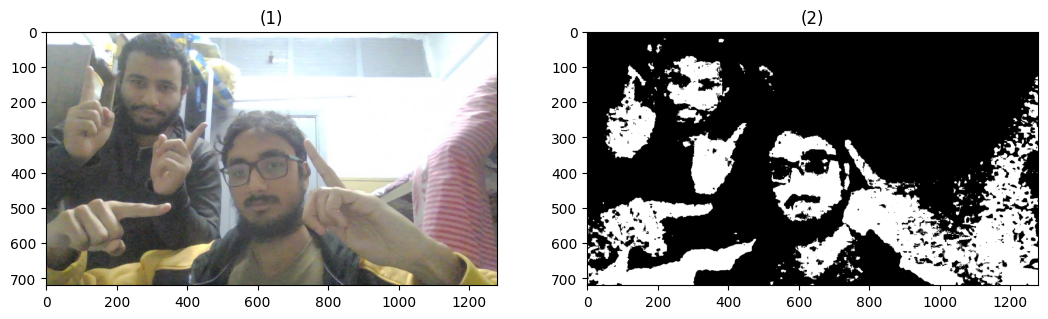

In [82]:

mainImg = img
R = img[:, :, 0]
G = img[:, :, 1]
B = img[:, :, 2]
Y = 0.299 * R + 0.587 * G + 0.114 * B
Cb = (B - Y) * 0.564 + 128
Cr = (R - Y) * 0.713 + 128
outImg = (Cb >= 77) * (Cb <= 127) * (Cr >= 133) * (Cr <= 180)
show_images([img, outImg])


In [76]:

# img = 255 * rgb2gray(img)
# th = getGlobalThreshold(img)
# edged = canny(img, 0.5, max(th - 100, 0), th)
# show_images([edged])


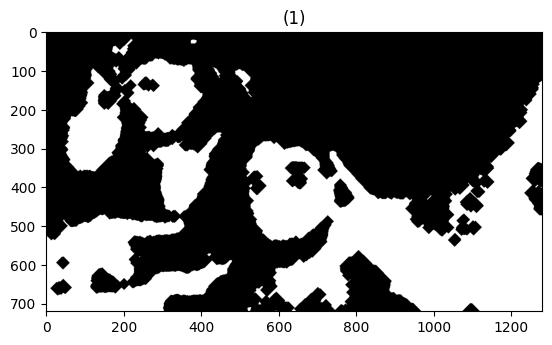

In [83]:
def enhance_image(img):
    se = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]]).astype('uint8')
    enhanced_image = np.array(img).astype('uint8')
    enhanced_image = cv.dilate(
        enhanced_image, se, iterations=15
    )
    enhanced_image = cv.erode(
        enhanced_image, se, iterations=15
    )
    return enhanced_image


enhanced = enhance_image(outImg)
show_images([enhanced])


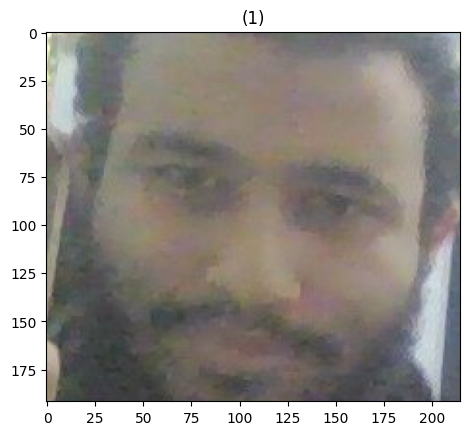

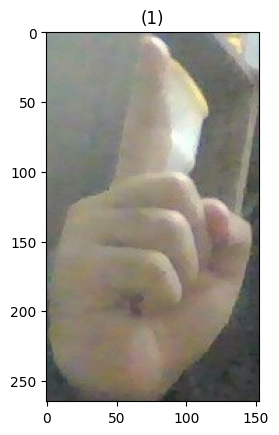

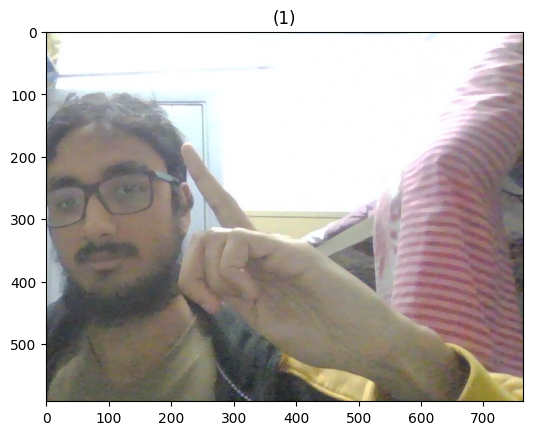

printed


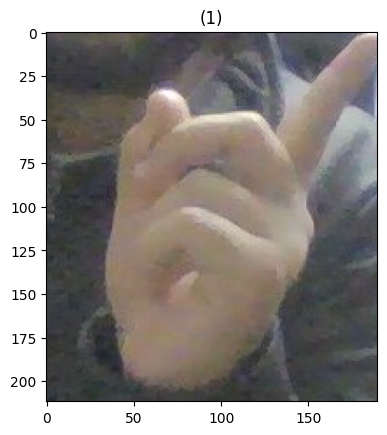

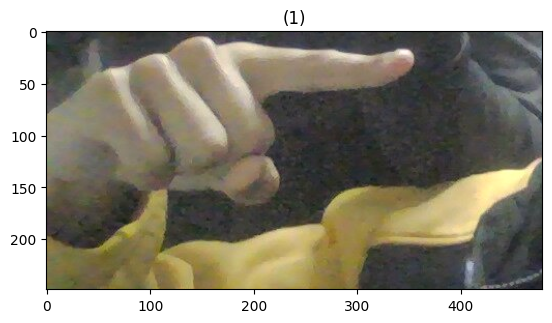

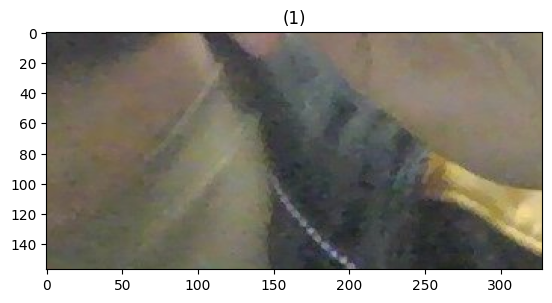

In [86]:

def detectHand(binaryImg, mainImg):
    contours = find_contours(binaryImg,  fully_connected='high')
    for contour in contours:
        Ymin = int(np.min(contour[:, 1]))
        Ymax = int(np.max(contour[:, 1]))
        Xmin = int(np.min(contour[:, 0]))
        Xmax = int(np.max(contour[:, 0]))
        if Xmax - Xmin >= 80 and Ymax - Ymin >= 80:
            detectedImage = np.array(mainImg[Xmin:Xmax, Ymin:Ymax])
            show_images([detectedImage])
            mp_hands = mp.solutions.hands
            hand = mp_hands.Hands()
            result = hand.process(detectedImage)
            if result.multi_hand_landmarks:
                print('printed')


detectHand(enhanced, mainImg)
